In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io
from astropy.stats.circstats import circcorrcoef

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from modelUtils import wrap_180, rot
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

from SacNetwork import SacNetwork
import balance_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib qt
plt.rcParams.update({"figure.max_open_warning": 0})

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

# TODO:
**timing offsets between EI for each direction:**
- collect input locations for EI synapses at each rho level
- calculate the time delta between E and I
- how does this change over direction?

In [4]:
model_path = os.path.join(base_path, "sanity")
fig_path = os.path.join(model_path, "figs") 
os.makedirs(fig_path, exist_ok=True)

dir_labels = np.array([225, 270, 315, 0, 45, 90, 135, 180])
circle = np.radians([0, 45, 90, 135, 180, 225, 270, 315, 0])
dir_rads = np.radians(dir_labels)
wrap_circ = lambda ds: np.concatenate((ds, [ds[0]]))
dirs_180 = np.array([ana.scale_180_from_360(d) for d in dir_labels])
dir_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
circ_180 = np.concatenate((dirs_180_sorted, [-dirs_180_sorted[0]]))

conf = configs.sac_mode_config()
probs = {
    t: {
        "null": conf["synprops"][t]["null_prob"],
        "pref": conf["synprops"][t]["pref_prob"],
    }
    for t in ["E", "I"]
}
conf["sac_theta_mode"] = "experimental"

Average GABA synapse count: 155.92


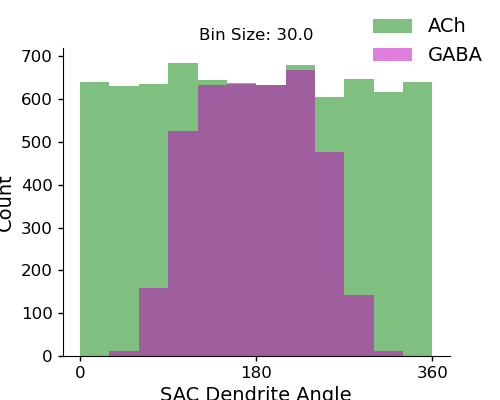

In [5]:
hist_conf = copy.deepcopy(conf)
hist_conf["seed"] = 4
hist_conf["sac_theta_mode"] = "experimental"
hist_nets = 25
angle_hist_fig, angle_hist_ax = ana.sac_angle_distribution(
    hist_conf, rho=1, n_nets=hist_nets, bins=[12], incl_yticks=True, figsize=(5, 4))
name = os.path.join(fig_path, "angle_hist_seed%i_%inets.png" % (hist_conf["seed"], hist_nets))
angle_hist_fig.savefig(name, bbox_inches="tight")

In [6]:
# TODO: get this working when synapses without I are included, such that
# this can be combined easily with a probability matrix including all of the synapses
# as well (so the E without I can count as "unopposed" when their probability is high enough,
# or be used as part of a linear metric that adds up the probabilities, modulated by the timing)
def calc_sweep_times(
    locs, # shape (N, 2 [EI], 2 [XY])
    origin,
    vel=1.0,
    rel_start=np.array([-150, 0]),
    rel_end=np.array([150, 0]),
):
    times = {}  # dir -> syn -> trans
    times = np.zeros((len(dir_rads), locs.shape[0], 2)) # shape (8 [dir], N, 2 [EI])
    for i, r in enumerate(dir_rads):
        line_a = rot(r, rel_start) + origin
        line_b = rot(r, rel_end) + origin
        for syn in range(locs.shape[0]):
            for j in range(2):
                dist = project_onto_line(line_a, line_b, locs[syn][j])[0]
                times[i, syn, j] = dist / vel
                
    return times

In [7]:
n_syns = 3000
rho_steps = 50
rhos = np.arange(rho_steps + 1) / rho_steps 

thetas, deltas, abs_deltas, dir_probs, times, has_gaba = [{} for _ in range(6)]
corrs, mean_abs_deltas = [], []

rng = np.random.default_rng()

for rho in rhos:
    sac_net = SacNetwork(
        np.zeros((n_syns, 2)),
        probs,
        rho,
        conf["sac_uniform_dist"],
        conf["sac_shared_var"],
        conf["sac_theta_vars"],
        conf["sac_gaba_coverage"],
        dir_labels,
        rng,
        offset=conf["sac_offset"],
        theta_mode=conf["sac_theta_mode"],
        cell_pref=0,
        n_plexus_ach=0,
    )
    # n = np.sum(sac_net.gaba_here)
    has_gaba[rho] = sac_net.gaba_here
    n = len(sac_net.gaba_here)
    ts = np.zeros((n, 2))
    ts[:, 0] = sac_net.thetas["E"]
    ts[:, 1] = sac_net.thetas["I"]
    thetas[rho] = ts
    paired_ts = ts[sac_net.gaba_here, :]
    corrs.append(circcorrcoef(np.radians(paired_ts[:, 0]), np.radians(paired_ts[:, 1])))
    deltas[rho] = np.vectorize(wrap_180)(paired_ts[:, 0] - paired_ts[:, 1])
    abs_deltas[rho] = np.abs(deltas[rho])
    mean_abs_deltas.append(np.mean(abs_deltas[rho]))
    locs = np.zeros((n, 2, 2))
    locs[:, 0, :] = sac_net.bp_locs["E"]
    locs[:, 1, :] = sac_net.bp_locs["I"]
    times[rho] = calc_sweep_times(locs, sac_net.origin)
    dir_probs[rho] = np.zeros((n, 8, 2))
    dir_probs[rho][:, :, 0] = sac_net.probs["E"]
    dir_probs[rho][:, :, 1] = sac_net.probs["I"]

corrs = np.array(corrs)

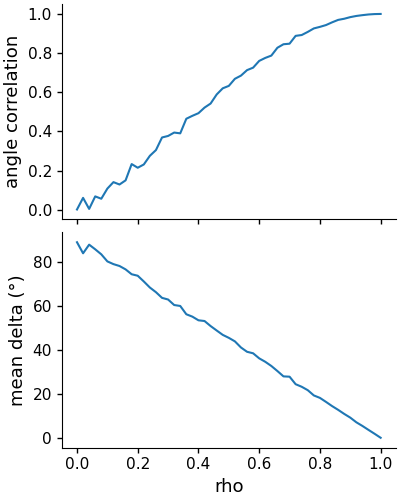

In [8]:
real_corr_fig, real_corr_ax = plt.subplots(2, 1, sharex=True, figsize=(4, 5))
real_corr_ax[0].plot(rhos, corrs)
real_corr_ax[0].set_ylabel("angle correlation", fontsize=13)
real_corr_ax[1].plot(rhos, mean_abs_deltas)
real_corr_ax[1].set_ylabel("mean delta (°)", fontsize=13)
real_corr_ax[-1].set_xlabel("rho", fontsize=13)
real_corr_fig.set_layout_engine("compressed")
clean_axes(real_corr_ax)
real_corr_fig.savefig(os.path.join(fig_path, "real_corr.png"), bbox_inches="tight")

In [9]:
e_early_thresh = 5.

time_diff = {r: ts[:, has_gaba[r], 1] - ts[:, has_gaba[r], 0] for r, ts in times.items()}
abs_time_diff = {r: np.abs(diffs) for r, diffs in time_diff.items()}
abs_time_diff_sum = {r: np.sum(diffs, axis=1) for r, diffs in abs_time_diff.items()}
e_early_diff_sum = {
    r: np.array([np.sum(d[d > 0.]) for d in diff]) 
    for r, diff in time_diff.items()
}
e_early = {r: (diffs > e_early_thresh) for r, diffs in time_diff.items()}
e_early_sum = {r: np.sum(early, axis=1) for r, early in e_early.items()}
total_prob = {r: np.sum(pr, axis=0) for r, pr in dir_probs.items()}

avg gaba coverage = 0.50


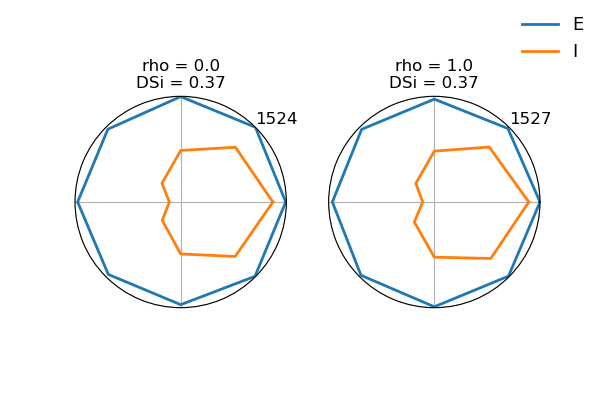

In [10]:
polar_rhos = [0.0, 1.0]
circ_total_prob = {r: pr[dir_sort, :] for r, pr in total_prob.items()}
circ_total_prob = {
    r: np.concatenate([pr, np.expand_dims(pr[0], axis=0)], axis=0) 
    for r, pr in circ_total_prob.items()
}

prob_polar_fig = plt.figure(figsize=(6, 4))
prob_polar_ax = []
for i, r in enumerate(polar_rhos):
    ax = prob_polar_fig.add_subplot(1, len(polar_rhos), i + 1, projection="polar")
    prob_polar_ax.append(ax)
    ax.plot(circle, circ_total_prob[r][:, 0], linewidth=2, label="E" if not i else None)
    ax.plot(circle, circ_total_prob[r][:, 1], linewidth=2, label="I" if not i else None)
    radius = np.max(circ_total_prob[r])
    dsi, _ = calc_tuning(total_prob[r][:, 1], dir_labels)
    ax.set_title("rho = " + str(r) + "\nDSi = %.2f" % dsi)
    ax.set_rmax(radius)
    ax.set_rticks([radius])
    ax.set_rlabel_position(45)
    ax.set_thetagrids([0, 90, 180, 270])
    ax.set_xticklabels([])
    ax.tick_params(labelsize=12)

prob_polar_fig.legend(fontsize=13, frameon=False)

print("avg gaba coverage = %.2f" % (np.mean([np.sum(g) for g in has_gaba.values()]) / n_syns))
prob_polar_fig.savefig(os.path.join(fig_path, "prob_polar.png"), bbox_inches="tight")

In [11]:
quanta_h5 = "/mnt/Data/prerna_velocity/static_roi_waveforms/quantum_pack.h5"
with h5.File(quanta_h5, "r") as f:
    quantum_pack = unpack_hdf(f)
    
release_rates = quantum_pack["clipped_rates"]
rec_dt = quantum_pack["rec_dt"]
target_rate_dt = 0.001  # 0.0001
bp_inputs = {("sust" if k == "PD" else "trans"): r for k, r in quantum_pack["aligned_recs"].items()}
bp_inputs["sust"] = bp_inputs["sust"] * np.max(bp_inputs["trans"]) / np.max(bp_inputs["sust"])

vrate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=target_rate_dt,
)
vrate = np.clip(vrate, 0.0, np.inf)

_rate = deconv.velocity_rate(
    bp_inputs["trans"],
    rec_dt,
    quantum_pack["quantum"],
    1,
    rf=0.06,
    spot=0.2,
    bsln_start=100,
    bsln_end=150,
    step=1,
    offset=0.,
    model_dt=0.005,
)


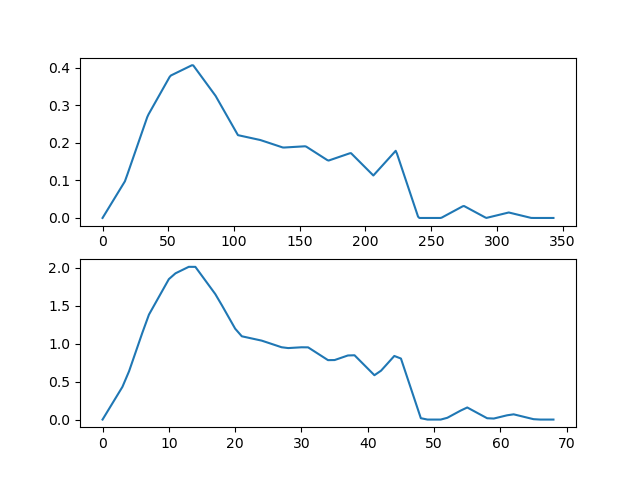

In [12]:
fff, aaa = plt.subplots(2)
aaa[0].plot(vrate)
aaa[1].plot(_rate)


In [13]:
from deconv import  poisson_of_release
def poisson_correlation_shared_base(rate):
    rng = np.random.default_rng()
    rho = 0.8
    inv_rho = 1 - rho
    # inv_rho = 1 - rho**2
    # inv_rho = np.sqrt(1 - rho**2)
    i_scale = 1
    e_scale = 0.8
    base_total, e_total, i_total, corr = [], [], [], []
    for _ in range(10000):
        base_psn = poisson_of_release(rng, rate * rho)
        e_psn = np.round(
            e_scale * (base_psn + poisson_of_release(rng, rate * inv_rho))
        ).astype(int)
        i_psn = np.round(
            i_scale * (base_psn + poisson_of_release(rng, rate * inv_rho))
        ).astype(int)

        base_total.append(np.sum(base_psn))
        i_total.append(np.sum(i_psn))
        e_total.append(np.sum(e_psn))
        corr.append(np.corrcoef(i_psn - rate * i_scale, e_psn - rate * e_scale)[0][1])

    print(
        "base total = %f\ni total = %f\ne total = %f\n corr = %f\n"
        % (np.mean(base_total), np.mean(i_total), np.mean(e_total), np.mean(corr))
    )

poisson_correlation_shared_base(_rate)

base total = 40.663000
i total = 50.807400
e total = 45.619100
 corr = 0.771076



In [14]:
def poisson_correlation_inhib_base(rate):
    rng = np.random.default_rng()
    rho = 0.6
    inv_rho = 1 - rho
    # inv_rho = 1 - rho**2
    # inv_rho = np.sqrt(1 - rho**2)
    # scale = 0.6
    scale = 1
    e_total, i_total, corr = [], [], []
    for _ in range(10000):
        i_psn = poisson_of_release(rng, rate)
        e_psn = np.round(
            scale * (i_psn * rho + poisson_of_release(rng, rate * inv_rho))
        ).astype(int)
        i_psn = np.round(scale * i_psn).astype(int)

        i_total.append(np.sum(i_psn))
        e_total.append(np.sum(e_psn))
        # corr.append(np.corrcoef(i_psn, e_psn)[0][1])
        corr.append(np.corrcoef(i_psn - np.mean(i_psn), e_psn - np.mean(e_psn))[0][1])

    print(
        "i total = %f\ne total = %f\n corr = %f\n"
        % (np.mean(i_total), np.mean(e_total), np.mean(corr))
    )
    
poisson_correlation_inhib_base(vrate)

i total = 50.582500
e total = 65.629600
 corr = 0.790595



In [15]:
n_syns = 3000
plex_counts = [0, 1, 2, 3]

ach_thetas, ach_dir_probs = {}, {}

rng = np.random.default_rng()

for n_plex in plex_counts:
    sac_net = SacNetwork(
        np.zeros((n_syns, 2)),
        probs,
        1.0,
        conf["sac_uniform_dist"],
        conf["sac_shared_var"],
        conf["sac_theta_vars"],
        conf["sac_gaba_coverage"],
        dir_labels,
        rng,
        offset=conf["sac_offset"],
        theta_mode=conf["sac_theta_mode"],
        cell_pref=0,
        n_plexus_ach=n_plex,
    )
    ts = np.zeros((n_syns, n_plex + 1))
    ts[:, 0] = sac_net.thetas["E"]
    if n_plex:
        ts[:, 1:] = sac_net.thetas["PLEX"]
    ach_thetas[n_plex] = ts
    ach_dir_probs[n_plex] = np.zeros((n_syns, 8, n_plex + 1))
    ach_dir_probs[n_plex][:, :, 0] = sac_net.probs["E"]
    if n_plex:
        ach_dir_probs[n_plex][:, :, 1:] = sac_net.probs["PLEX"]

ach_total_prob = {n: pr.mean(axis=0).sum(axis=1) for n, pr in ach_dir_probs.items()}
circ_ach_total_prob = {n: pr[dir_sort] for n, pr in ach_total_prob.items()}
circ_ach_total_prob = {
    n: np.concatenate([pr, np.expand_dims(pr[0], axis=0)], axis=0) 
    for n, pr in circ_ach_total_prob.items()
}

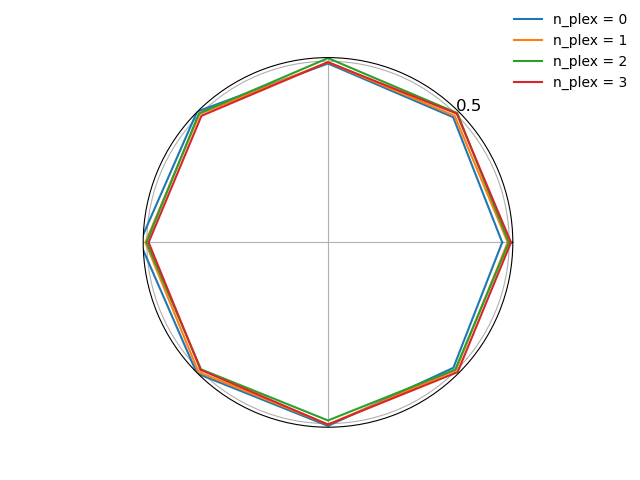

In [16]:
ach_tuning_plex_polar_fig = plt.figure()
ach_tuning_plex_polar_ax = ach_tuning_plex_polar_fig.add_subplot(111, projection="polar")
for n, prs in circ_ach_total_prob.items():
    ach_tuning_plex_polar_ax.plot(circle, prs, label="n_plex = %i" % n)
    
ach_tuning_plex_polar_ax.set_rmax(0.51)
ach_tuning_plex_polar_ax.set_rticks([0.5])
ach_tuning_plex_polar_ax.set_rlabel_position(45)
ach_tuning_plex_polar_ax.set_thetagrids([0, 90, 180, 270])
ach_tuning_plex_polar_ax.set_xticklabels([])
ach_tuning_plex_polar_ax.tick_params(labelsize=12)
ach_tuning_plex_polar_fig.legend(frameon=False)

n_plex 0
  variance 0.0001644274326816516
  range 0.0385791831816204
n_plex 1
  variance 1.4017505188925972e-05
  range 0.01146788995596204
n_plex 2
  variance 2.6984988549524158e-05
  range 0.017143075340259994
n_plex 3
  variance 1.8830102909930734e-05
  range 0.012090887771053382


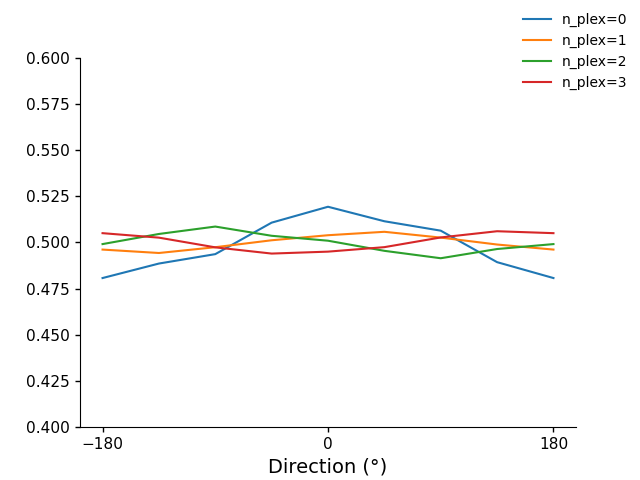

In [17]:
ach_tuning_plex_fig, ach_tuning_plex_ax = plt.subplots(1)
for n, prs in circ_ach_total_prob.items():
    ach_tuning_plex_ax.plot(circ_180, prs, label="n_plex=%i" % n)
    print("n_plex %i\n  variance %s\n  range %s" % (n, np.var(prs[:-1]), np.max(prs) - np.min(prs)))

ach_tuning_plex_ax.set_ylim(0.4, 0.6)
ach_tuning_plex_ax.set_xticks([-180, 0, 180])
ach_tuning_plex_ax.set_xlabel("Direction (°)", fontsize=14)
ach_tuning_plex_fig.legend(frameon=False)
clean_axes(ach_tuning_plex_ax)